# Vertical deflection of a Kirchhoff-Love Plate

The goal of this notebook is to treat an ice shelf as a rectangular thin plate, load it with some surface mass balance, and calculate the vertical elastic deflection. This notebook references a 2007 text by Dietrich Braess, [online lecture notes](https://mycourses.aalto.fi/pluginfile.php/896791/mod_resource/content/3/CIV-E4090-2019-Lectures2.pdf) by Jarkko Niiranen, and [MacAyeal et al., 2021](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3). I sketch the derivation of the weak form of the Kirchhoff plate problem, solve the weak form using Firedrake, and verify that the solution preserves the original force balance constraint.

In [1]:
from firedrake import *
import matplotlib.pyplot as plt

# Deriving the variational form to be solved

## Strong form (force balance)

The stress balance for a Kirchhoff-Love plate states that 

\begin{equation}
    -\nabla\cdot\left(\nabla\cdot\vec{M}\right) = f(x, y).
\end{equation}
This condition, when expanded out, is equivalent to Equation 46 in MacAyeal et al. Also see pg. 84 of Jarkko Niiranen's [lecture notes](https://mycourses.aalto.fi/pluginfile.php/896791/mod_resource/content/3/CIV-E4090-2019-Lectures2.pdf). In this context, $f(x, y)$ has units of stress (e.g., see Eq. 57 in MacAyeal et al.), and so the moment $\vec{M}$ has units of force (as in Eq. 18 of MacAyeal et al.). 


## Constitutive relation

In this section, I derive the relationship between $\vec{M}$ and the vertical deflection, $\eta$. Toward this goal, note first that the moment tensor relates to the stress tensor $\vec{\sigma}$ via

$$\vec{M} = \int_{-\frac{H}{2}}^\frac{H}{2}\zeta\vec{\sigma}d\zeta,$$
where $H$ is the thickness of the plate. Under a plane stress regime, the stress tensor relates, in turn, to the strain tensor $\vec{\varepsilon}$ as shown below (Eq. 4.3 on pg. 315 of the Dietrich Braess text):

$$\vec{\sigma} = \frac{E}{1 + \mu}\left(\vec{\varepsilon} + \frac{\mu}{1 - \mu}tr(\vec{\varepsilon})\vec{I}\right).$$

Here, $E$ is Young's Modulus, and $\mu$ is Poisson's Ratio. Choose values for $E$ and $\mu$ below:


In [2]:
E = 1e12 #Young's Modulus in Pacals. Suggested value by MacAyeal et al. is 1e9 Pa, but this results in too-large deflections
μ = 1/3 #Poisson's Ration (unitless). Value from MacAyeal et al.

Finally, under the hypotheses of Kirchhoff-Love, the strain tensor relates to $\eta$ via

$$\vec{\varepsilon} = -\zeta\nabla^2\eta.$$

The resulting constitutive relation connecting $\vec{M}$ with $\eta$ is

$$\vec{M} = -\frac{EH^3}{12(1+\mu)}\left(\nabla^2\eta + \frac{\mu}{1 - \mu}tr(\nabla^2\eta)\vec{I}\right).$$

## Weak form

To obtain the weak form, multiply both sides of the governing equation by an arbitrary weight function $v(x, y)$, and integrate over the domain, so that

$$ -\int_{x, y}\nabla\cdot(\nabla\cdot\vec{M})v(x, y)dxdy = \int_{x, y}f(x, y)v(x, y)dxdy.$$

Integrate by parts twice, following pg. 93 of Jarkko Niiranen's [lecture notes](https://mycourses.aalto.fi/pluginfile.php/896791/mod_resource/content/3/CIV-E4090-2019-Lectures2.pdf), to find that

$$-\int_{x, y}\vec{M}:\nabla^2v(x, y)dxdy = \int_{x, y}f(x, y)v(x, y)dxdy,$$

where I have left out the boundary terms (since we'll just use the penalty method to include any desired boundary conditions anyway). Use the above constitutive relation, noting that $tr(\nabla^2\eta)\vec{I}:\nabla^2v = \Delta\eta\Delta v$, to obtain the weak form of the problem:

$$\frac{EH^3}{12(1 + \mu)}\int_{x, y}\nabla^2\eta : \nabla^2 vdxdy + \frac{EH^3\mu}{12(1 + \mu)(1 - \mu)}\int_{x, y}\Delta\eta\Delta v dxdy + \int_{x, y}f(x, y)v(x, y)dxdy = 0.$$

For brevity, introduce the symbols $\lambda_1 := \frac{E}{1 + \mu}$ and $\lambda_2 := \frac{E\mu}{(1 + \mu)(1 - \mu)}$.

In [3]:
λ_1 = E/(1 + μ)
λ_2 = λ_1*μ/(1 - μ)

The weak form to be solved is now

$$\lambda_1\frac{H^3}{12}\int_{x, y}\nabla^2\eta : \nabla^2 vdxdy + \lambda_2\frac{H^3}{12}\int_{x, y}\Delta\eta\Delta v dxdy + \int_{x, y}f(x, y)v(x, y)dxdy = 0.$$

# Solving the problem with Firedrake

## Spatial extent and mesh

In [4]:
nx, ny = 100, 50
Lx, Ly = 10000, 5000 #5 km long by 1 km wide shelf
mesh = RectangleMesh(nx, ny, Lx, Ly)

x, y = SpatialCoordinate(mesh)
Q = FunctionSpace(mesh, 'Argyris', 5) #Argyris elements of order 5 are needed to solve this 4th-order problem

## Physical parameters

In [5]:
ρ_i = 917 #ice density in kg/m^3
ρ_w = 1018 #saltwater density in kg/m^3
g = 9.81 #g in N/kg
H0 = 100 #initial shelf thickness in meters

## Trial and test functions, and their gradients

In [6]:
#trial function η and its gradients
η = Function(Q) #the deflection to be solved for
ddη = grad(grad(η)) #∇^2(η)
Δη = div(grad(η)) #the laplacian of η

#test function and its gradients
v = TestFunction(Q) 
ddv = grad(grad(v))
Δv = div(grad(v)) #the laplacian of v

## Load on the shelf

I'll load the shelf by imposing a spatially uniform surface mass balance, $SMB$, at the top. The load resulting from imposing this surface mass balance is a bit complex. For example, if $SMB$ is negative, thickness is removed from the surface, resulting in a net buoyant force; the buoyant force results in an upward deflection which, in turn, will act to reduce the buoyant force causing the deflection. (A similar interaction occurs if $SMB$ is positive.) Below, I derive the appropriate relationship between $SMB$, $\eta$ and the load $f$:

 - Before loading, the initial surface elevation is $s_0 = \left(1 - \frac{\rho_i}{\rho_w}\right)H_0$
 - After loading and deflecting, the surface elevation becomes $s = \left(1 - \frac{\rho_i}{\rho_w}\right)H_0 + SMB + \eta$
 - Noting that deflections do not influence thickness, the updated thickness becomes $H = H_0 + SMB$
 - Given the updated thickness, the equilibrium surface elevation would now be $s_{eq} = \left(1 - \frac{\rho_i}{\rho_w}\right)(H_0 + SMB)$
 - The height above/below buoyancy is $h_{ab} := s - s_{eq} = \frac{\rho_i}{\rho_w}SMB + \eta$
 - If $h_{ab} < 0$, the force on the shelf acts upward and attains value $f = -\rho_wgh_{ab}$
 - If $h_{ab} \geq 0$, the force on the shelf acts downward and attains value $f = -\rho_igh_{ab}$
 
 Therefore, the appropriate load on the shelf due to surface mass balance is given by:
 
 $$f = \begin{cases} -\rho_igSMB - \rho_wg\eta & \frac{\rho_i}{\rho_w}SMB + \eta < 0\\
 -\frac{\rho_i^2}{\rho_w}gSMB - \rho_ig\eta & \frac{\rho_i}{\rho_w}SMB + \eta \geq 0
 \end{cases}$$

In [7]:
SMB = Constant(-1) #net surface accumulation/ablation in meters
f = conditional(ρ_i/ρ_w*SMB + η < 0, -ρ_i*g*SMB - ρ_w*g*η, -ρ_i**2/ρ_w*g*SMB - ρ_i*g*η)

## Set up the problem to be solved

Solving the weak form is equivalent to minimizing the expression:

$$\Pi(\eta, v) = \lambda_1\frac{H^3}{12}\int_{x, y}\nabla^2\eta : \nabla^2 v dxdy + \lambda_2\frac{H^3}{12}\int_{x, y}\Delta\eta\Delta vdxdy - \int_{x, y}f(x, y)v(x, y)dxdy$$

subject to some boundary conditions. I'll impose no-slip boundary conditions at the sidewalls and the upstream boundary, so that $\eta = 0$ on boundaries 1, 3 and 4. Constraints will be enforced via the penalty method. 

In [8]:
L = (λ_1*(H0**3)/12*inner(ddη, ddv))*dx
L += λ_2*(H0**3)/12*Δη*Δv*dx 
L -= f*v*dx

######################################
######################################
### What value should I use for α? ###
######################################
######################################

α = 1e10 
L += 0.5*α**2*(η*v)*ds(1) #η = 0 on boundary 3, via penalty method
L += 0.5*α**2*(η*v)*ds(3) #η = 0 on boundary 3
L += 0.5*α**2*(η*v)*ds(4) #η = 0 on boundary 4

## Solve and plot

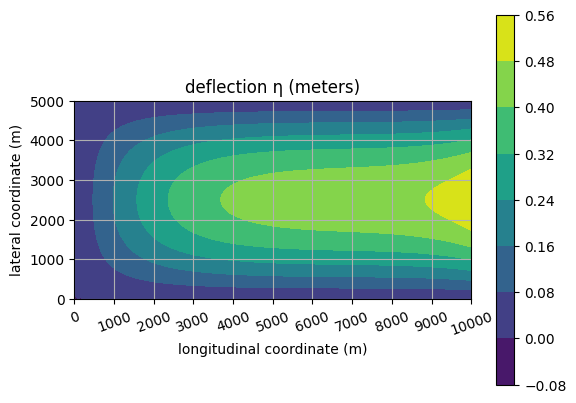

In [9]:
solve(L == 0, η)

fig, ax = plt.subplots()
ax.set_aspect('equal')
colors = tricontourf(η, axes = ax)
plt.colorbar(colors)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.title('deflection η (meters)')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()

# Verify that the solution satisfies the force balance

If everything went right, we should have that $\nabla\cdot\left(\nabla\cdot\vec{M}(\eta)\right) + f(x, y) = 0$. As shown below, this condition isn't perfectly met (especially near corners), but it does seem to get smaller and smaller as the mesh is refined. 

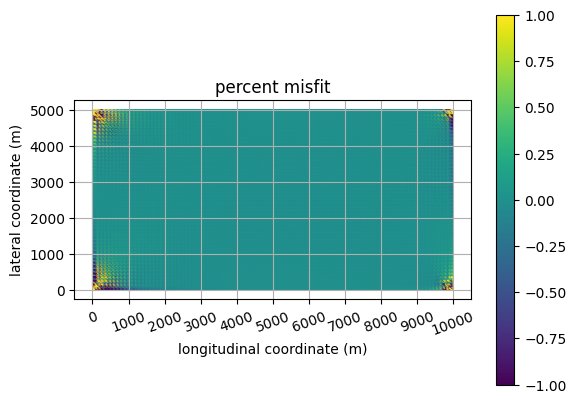

In [10]:
M = -H0**3/12*(λ_1*ddη + λ_2*tr(ddη)*Identity(2)) #the tensor M, as obtained earlier
misfit = project((div(div(M)) + f)/f*100, Q) #should ideally be very small

fig, ax = plt.subplots()
ax.set_aspect('equal')
colors = tripcolor(misfit, axes = ax, vmax = 1, vmin = -1)
plt.colorbar(colors)
plt.xticks(range(0, Lx + 1, 1000), rotation=20)
plt.title('percent misfit')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()

# Update surface elevation

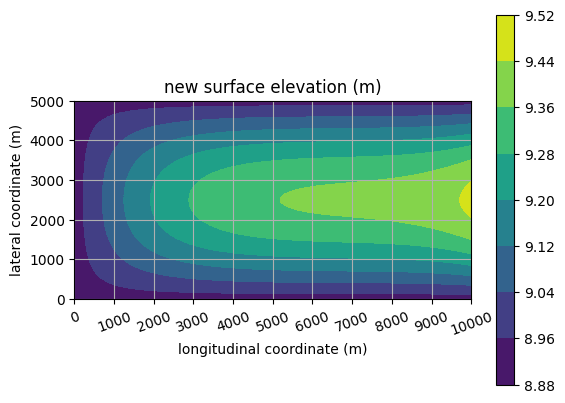

In [11]:
s = project((1 - ρ_i/ρ_w)*H0 + SMB + η, Q) #s = s0 + SMB + η
#hab = project(ρ_i/ρ_w*SMB + η, Q) #height above buoyancy

fig, ax = plt.subplots()
ax.set_aspect('equal')
colors = tricontourf(s, axes = ax)
plt.colorbar(colors)
plt.xticks(range(0, Lx + 1, 1000), rotation=20)
plt.title('new surface elevation (m)')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()

# Postprocessing

Eventually, we'll want to think about fracture mechanics, which will require looking at the stress state. Calculate the stress tensor via the relationship

$$\vec{\sigma} = -\zeta\frac{E}{1 + \mu}\left(\nabla^2\eta + \frac{\mu}{1 - \mu}tr(\nabla^2\eta)\vec{I}\right).$$


In [12]:
# σ_surf = -1/2*λ_1*H0*ddη - 1/2*λ_2*H0*tr(ddη)*Identity(2) #stress tensor at the surface (ζ = H/2)
# σxx = project(σ_surf[0, 0], Q) #σ_xx evaluated at the surface of the plate 
# σyy = project(σ_surf[0, 0], Q) #σ_yy evaluated at the surface of the plate 

# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# colors = tricontourf(σxx, axes = ax)
# plt.colorbar(colors)
# plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
# plt.title('net stress @ surface (Pa)')
# plt.xlabel('longitudinal coordinate (m)')
# plt.ylabel('lateral coordinate (m)')
# plt.grid()